In [26]:
import os, sys, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
data_path = '../../../movie_rec/data/train'

org_train_ratings = pd.read_csv(os.path.join(data_path, 'train_ratings.csv'))
org_titles = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
org_genres = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')

In [43]:
# 멀티 레이블된 genre를 아이템별로 합치기
genres_by_item = org_genres.groupby('item')['genre'].apply(list).reset_index()

# Merge the data
data = pd.DataFrame()
data = pd.merge(org_train_ratings, org_titles, on='item')
data = pd.merge(data, genres_by_item, on='item')
data['time'] = pd.to_datetime(data['time'], unit='s')
data.head()

,user,item,time,title,genre
0,11,4643,2009-01-01 04:02:09,Planet of the Apes (2001),"[Action, Adventure, Drama, Sci-Fi]"
1,11,170,2009-01-01 04:02:14,Hackers (1995),"[Action, Adventure, Crime, Thriller]"
2,11,531,2009-01-01 04:02:19,"Secret Garden, The (1993)","[Children, Drama]"
3,11,616,2009-01-01 04:02:22,"Aristocats, The (1970)","[Animation, Children]"
4,11,2140,2009-01-01 04:02:43,"Dark Crystal, The (1982)","[Adventure, Fantasy]"


# 사용자 분석

In [44]:
interaction_by_user = data.groupby('user')['time'].apply(list).reset_index()
interaction_by_user.head()

,user,time
0,11,"[2009-01-01 04:02:09, 2009-01-01 04:02:14, 200..."
1,14,"[2008-10-29 19:32:26, 2008-10-29 19:32:37, 200..."
2,18,"[2007-11-20 15:39:55, 2007-11-20 15:40:48, 200..."
3,25,"[2010-07-01 05:20:18, 2010-07-01 05:20:30, 201..."
4,31,"[2015-02-23 23:17:13, 2015-02-23 23:17:15, 201..."


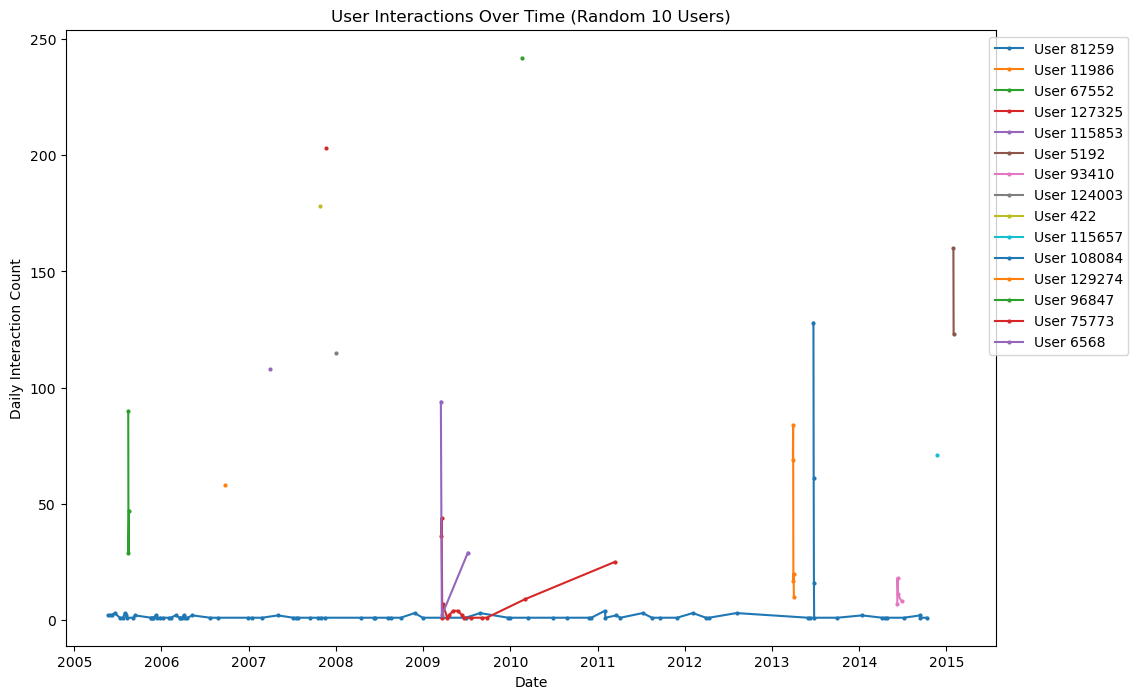

In [45]:
import random

# 사용자 ID를 랜덤하게 10명 선택
random_users = interaction_by_user.sample(n=15, random_state=42)

plt.figure(figsize=(12, 8))

# 선택된 사용자들의 일별 상호작용 개수 그래프 그리기
for index, row in random_users.iterrows():
    daily_counts = pd.Series(row['time']).dt.date.value_counts().sort_index()
    plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-', markersize=2, label=f'User {row["user"]}')

plt.xlabel('Date')
plt.ylabel('Daily Interaction Count')
plt.title('User Interactions Over Time (Random 10 Users)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

- 사용자들은 대부분 짧은 시간에 데이터를 평가하는 경향이 있음

In [46]:
df = data.copy()
# 유저별 평가 횟수 계산
user_interactions = df.groupby('user').size().reset_index(name='count')

threshold = user_interactions['count'].quantile(0.9)

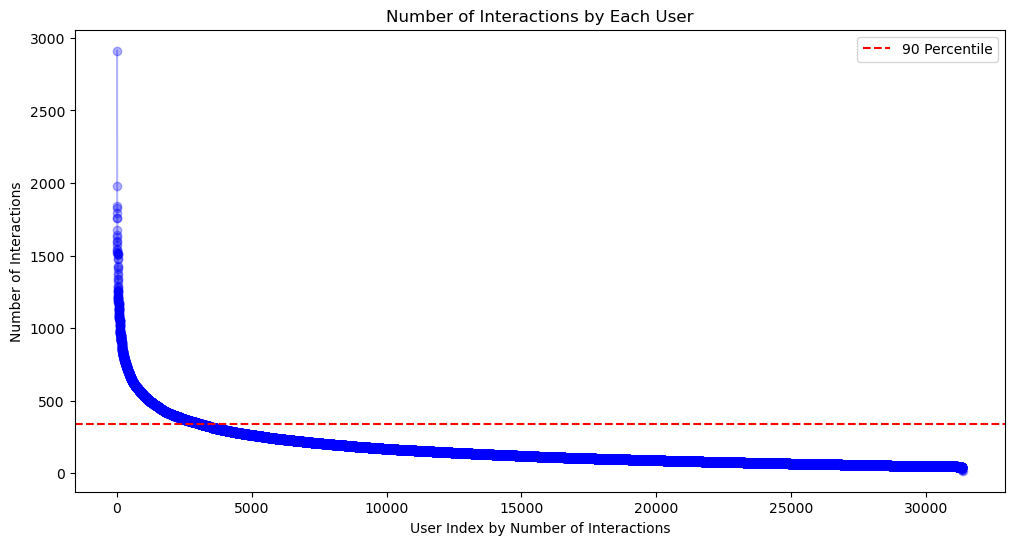

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(user_interactions['count'].sort_values(ascending=False).values, marker='o', linestyle='-', color='b', alpha=0.3)
plt.axhline(y=threshold, color='r', linestyle='--', label='90 Percentile')
plt.xlabel('User Index by Number of Interactions')
plt.ylabel('Number of Interactions')
plt.title('Number of Interactions by Each User')
plt.legend()
plt.show()

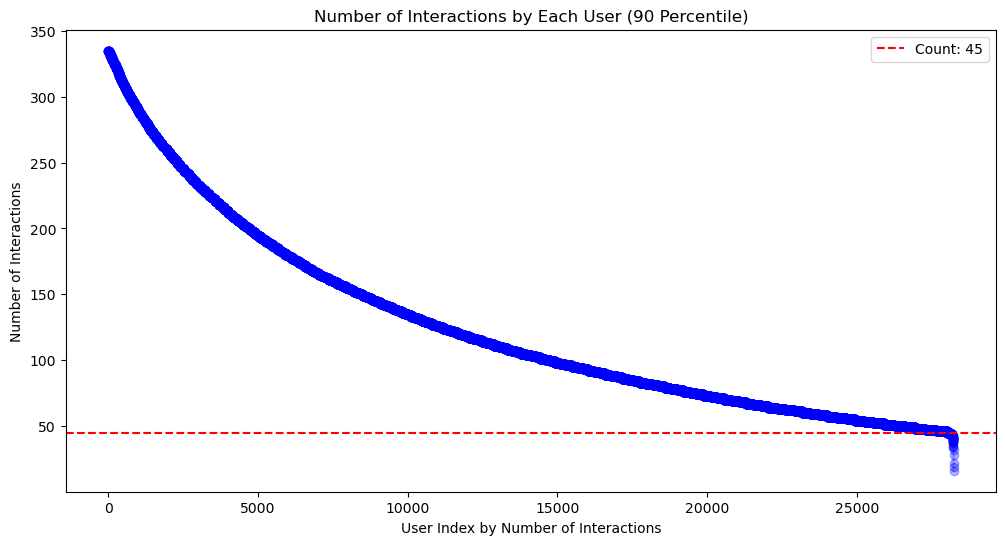

In [50]:
under_threshold = user_interactions[user_interactions['count'] <= threshold]

plt.figure(figsize=(12, 6))
plt.plot(under_threshold['count'].sort_values(ascending=False).values, marker='o', linestyle='-', color='b', alpha=0.3)
plt.xlabel('User Index by Number of Interactions')
plt.axhline(y=45, color='r', linestyle='--', label='Count: 45')
plt.ylabel('Number of Interactions')
plt.title('Number of Interactions by Each User (90 Percentile)')
plt.legend()
plt.show()

- 335개 이하의 아이템을 평가한 유저는 기본적으로 고르게 지수적으로 감소하는 추세를 보이나, 약 45개 미만의 아이템을 평가한 유저는 103명, 전체의 0.3%로 해당 개수 이하 현저히 감소함

# 활동량에 근거한 heavy 유저와 light 유저간의 특징이 있을까?

Threshold: 450.0499999999993


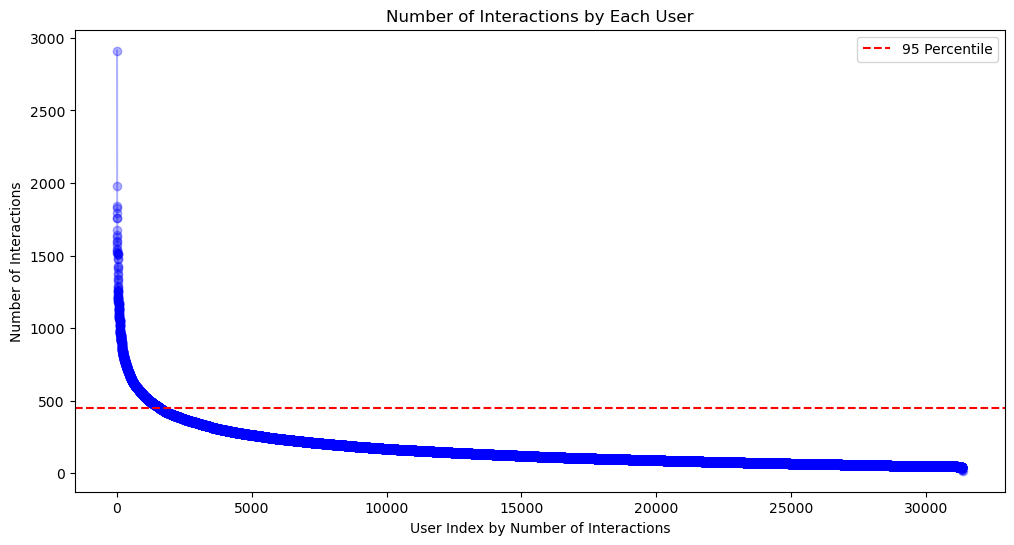

In [53]:
# threshold를 전체 유저의 95% quantile로 설정
threshold = user_interactions['count'].quantile(0.95)
print(f'Threshold: {threshold}')
plt.figure(figsize=(12, 6))
plt.plot(user_interactions['count'].sort_values(ascending=False).values, marker='o', linestyle='-', color='b', alpha=0.3)
plt.axhline(y=threshold, color='r', linestyle='--', label='95 Percentile')
plt.xlabel('User Index by Number of Interactions')
plt.ylabel('Number of Interactions')
plt.title('Number of Interactions by Each User')
plt.legend()
plt.show()

In [ ]:
# 유저 타입을 heavy와 light로 정의
user_interactions['type'] = user_interactions['count'].apply(lambda x: 'heavy' if x > threshold else 'light')
user_interactions.head()

,user,count,type
0,11,376,light
1,14,180,light
2,18,77,light
3,25,91,light
4,31,154,light


In [57]:
# 데이터셋을 heavy와 light 유저로 나누기
heavy_user_data = data[data['user'].isin(user_interactions[user_interactions['type'] == 'heavy']['user'])]
light_user_data = data[data['user'].isin(user_interactions[user_interactions['type'] == 'light']['user'])]

print(f'Heavy User Data Shape: {heavy_user_data.shape}')
print(f'Light User Data Shape: {light_user_data.shape}')

Heavy User Data Shape: (1015477, 5)
Light User Data Shape: (4138994, 5)


In [91]:
# heavy user와 light user의 아이템별 상호작용 개수 계산
items_by_heavy = heavy_user_data.groupby('item').size().reset_index(name='count')
items_by_light = light_user_data.groupby('item').size().reset_index(name='count')

print(items_by_heavy.head(10))
print(items_by_light.head(10))

   item  count
0     1   1067
1     2    496
2     3    184
3     4     18
4     5    130
5     6    821
6     7    159
7     8     17
8     9     31
9    10    612
   item  count
0     1  11150
1     2   2868
2     3    550
3     4     25
4     5    460
5     6   4303
6     7    640
7     8     31
8     9     35
9    10   3674


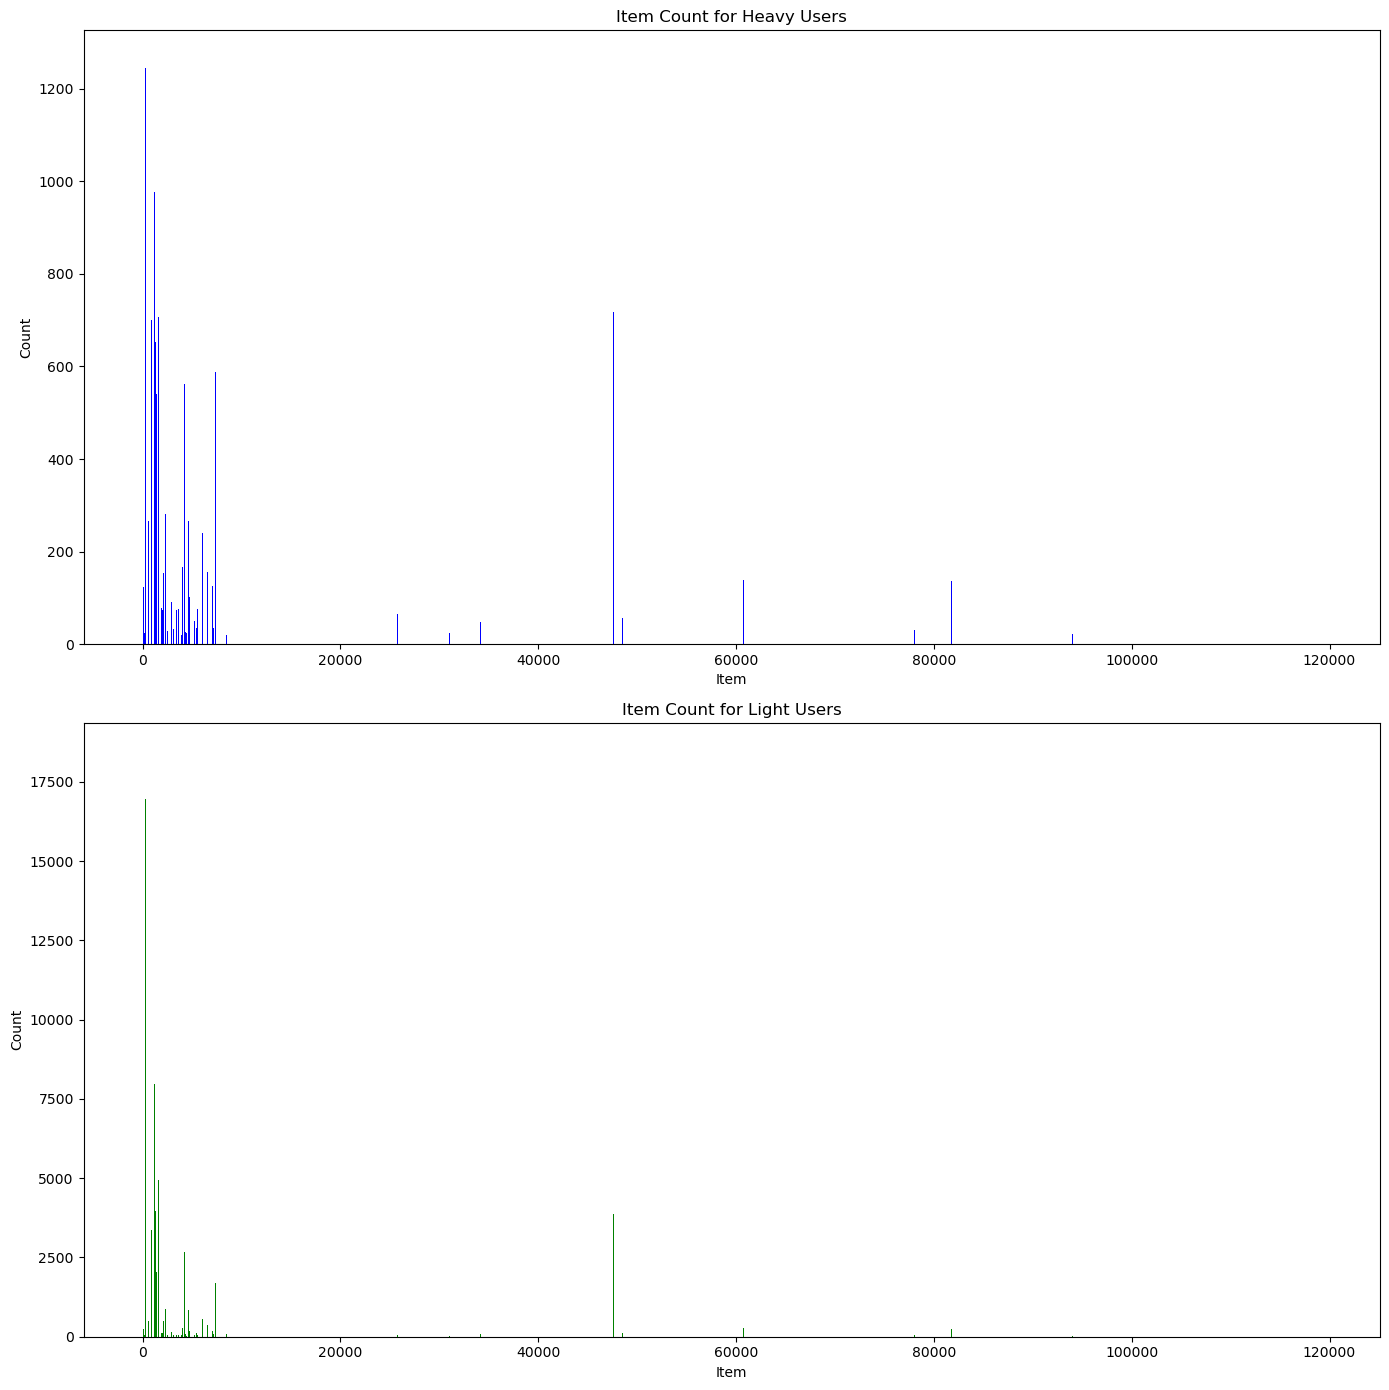

In [100]:
plt.figure(figsize=(14, 14))

# Heavy users
plt.subplot(2, 1, 1)
plt.bar(items_by_heavy['item'], items_by_heavy['count'], color='blue', alpha=1)
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('Item Count for Heavy Users')

# Light users
plt.subplot(2, 1, 2)
plt.bar(items_by_light['item'], items_by_light['count'], color='green', alpha=1)
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('Item Count for Light Users')

plt.tight_layout()
plt.show()

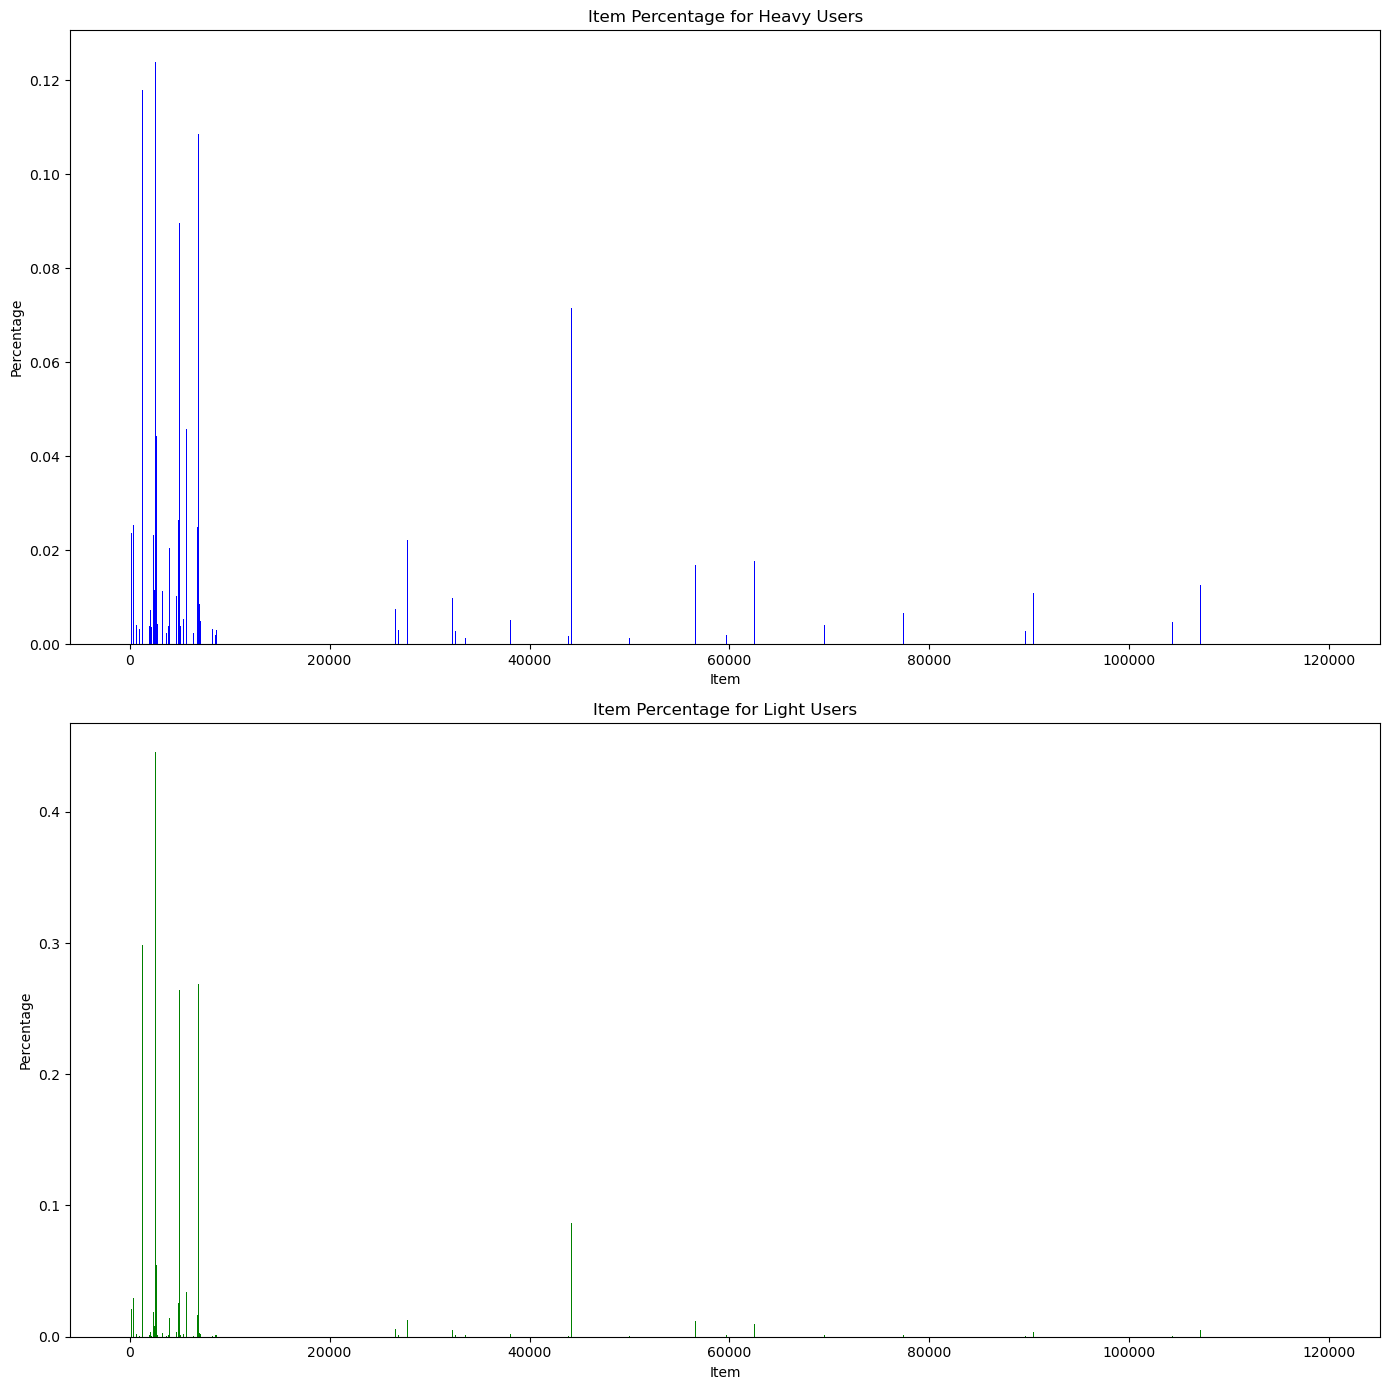

In [107]:
# 비율 계산
items_by_heavy['percentage'] = 100*items_by_heavy['count'] / items_by_heavy['count'].sum()
items_by_light['percentage'] = 100*items_by_light['count'] / items_by_light['count'].sum()

plt.figure(figsize=(14, 14))

# Heavy Users
plt.subplot(2, 1, 1)
plt.bar(items_by_heavy['item'], items_by_heavy['percentage'], color='blue', alpha=1)
plt.xlabel('Item')
plt.ylabel('Percentage')
plt.title('Item Percentage for Heavy Users')

# Light Users
plt.subplot(2, 1, 2)
plt.bar(items_by_light['item'], items_by_light['percentage'], color='green', alpha=1)
plt.xlabel('Item')
plt.ylabel('Percentage')
plt.title('Item Percentage for Light Users')

plt.tight_layout()
plt.show()

- heavy 유저와 light 유저간의 평가 아이템은 크게 차이나지 않음

# User별 time 피처를 통한 중간 누락된 time 유추

In [131]:
user_list = data['user'].unique()
user_list

array([    11,     14,     18, ..., 138486, 138492, 138493])

In [135]:
user_11 = data[data['user'] == 11]
user_11['time_gap'] = user_11['time'].diff().dt.total_seconds().fillna(0)

user_14 = data[data['user'] == 14]
user_14['time_gap'] = user_14['time'].diff().dt.total_seconds().fillna(0)

user_18 = data[data['user'] == 18]
user_18['time_gap'] = user_18['time'].diff().dt.total_seconds().fillna(0)

/var/folders/68/zvjwc4g973dgknpsjc6dy3g00000gn/T/ipykernel_4947/1480206475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_11['time_gap'] = user_11['time'].diff().dt.total_seconds().fillna(0)
/var/folders/68/zvjwc4g973dgknpsjc6dy3g00000gn/T/ipykernel_4947/1480206475.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_14['time_gap'] = user_14['time'].diff().dt.total_seconds().fillna(0)
/var/folders/68/zvjwc4g973dgknpsjc6dy3g00000gn/T/ipykernel_4947/1480206475.py:8: SettingWithCopyWarning: 
A va

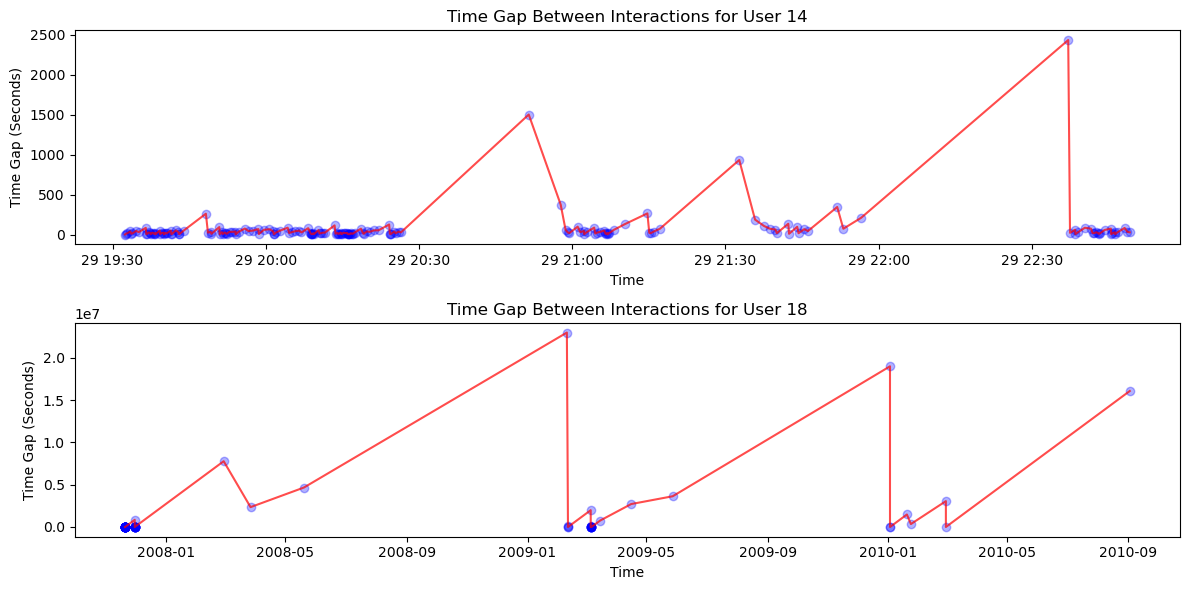

In [143]:
plt.figure(figsize=(12, 6))

# User 14 - Scatter and Line
plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 그래프
plt.scatter(user_14['time'], user_14['time_gap'], color='b', alpha=0.3, label='Scatter')
plt.plot(user_14['time'], user_14['time_gap'], linestyle='-', color='r', alpha=0.7, label='Line')
plt.xlabel('Time')
plt.ylabel('Time Gap (Seconds)')
plt.title('Time Gap Between Interactions for User 14')

# User 18 - Scatter and Line
plt.subplot(2, 1, 2)  # 2행 1열의 두 번째 그래프
plt.scatter(user_18['time'], user_18['time_gap'], color='b', alpha=0.3, label='Scatter')
plt.plot(user_18['time'], user_18['time_gap'], linestyle='-', color='r', alpha=0.7, label='Line')
plt.xlabel('Time')
plt.ylabel('Time Gap (Seconds)')
plt.title('Time Gap Between Interactions for User 18')

plt.tight_layout()  # 그래프 간 간격 자동 조정
plt.show()